# Diversity inducing distributions

To approaches to select $k$ diverse elements from a larger set, we look into two approaches:

- [MRFs](#Repulsive-Markov-Random-Fields)
- [DPPs](#Determinantal-Point-Processes)


In [ ]:
# from chmp.ipynb import notebook_preamble; notebook_preamble()
%matplotlib inline
# disable rescaling the figure, to gain tighter control over the result
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [ ]:
import collections
import itertools as it
import math
import random

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd

from chmp.ds import mpl_set

In [ ]:
def random_nonzero_choice(a, n_nonzero=-1):
    if n_nonzero <= 0:
        n_nonzero = np.sum(a)
    
    return _random_nonzero_choice(np.asarray(a, bool), np.int64(n_nonzero))
    
    
@numba.jit('int64(boolean[:], int64)', nopython=True, nogil=True)
def _random_nonzero_choice(a, n_nonzero):
    j = random.randrange(0, n_nonzero)
    i_max = -1
    
    for i, v in enumerate(a):
        if v:
            j -= 1
            i_max = i
        
        if j < 0:
            return i
    
    return i_max


def random_weighted_zero_choice(a, p):
    return _random_weighted_zero_choice(np.asarray(a, np.bool), np.asarray(p, np.float64))


@numba.jit('int64(boolean[:], float64[:])', nopython=True, nogil=True)
def _random_weighted_zero_choice(a, p):
    threshold = 0.0
    for q in p:
        threshold += q
    
    threshold = threshold * random.random()
    
    pi = 0
    
    i_max = -1
    
    for i, v in enumerate(a):
        if v:
            continue
        
        i_max = i
        threshold -= p[pi]
        pi += 1
        
        if threshold <= 0:
            return i
    
    return i_max


def det_change(D, B, L_sub_inv, p_out=None):
    if p_out is None:
        p_out = np.zeros_like(D, dtype=np.float64)
        
    else:
        p_out = np.asarray(p_out, np.float64)
    
    _det_change(
        np.asarray(D, np.float64), 
        np.asarray(B, np.float64), 
        np.asarray(L_sub_inv, np.float64), 
        p_out,
    )
    
    return p_out


@numba.jit('void(float64[:], float64[:, :], float64[:, :], float64[:])', nogil=True, nopython=True)
def _det_change(D, B, L_sub_inv, p_out):
    # p = D - np.diag(B.T @ L_sub_inv @ B)
    for k in range(len(p_out)):
        tmp = 0.0
        
        for i in range(L_sub_inv.shape[0]):
            for j in range(L_sub_inv.shape[1]):
                tmp += L_sub_inv[i, j] * B[i, k] * B[j, k]
        
        p_out[k] = D[k] - tmp

In [ ]:
param_n = 6
param_k = 3
phi = np.linspace(0, 2 * np.pi, param_n + 1)[:param_n]

states = [
    [int(i in active) for i in range(param_n)] 
    for active in it.combinations(range(param_n), param_k)
]

euclidean_distance = 2 * (1 - np.cos(phi[:, None] - phi[None, :]))

In [ ]:
states[:10]

[[1, 1, 1, 0, 0, 0],
 [1, 1, 0, 1, 0, 0],
 [1, 1, 0, 0, 1, 0],
 [1, 1, 0, 0, 0, 1],
 [1, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 1],
 [1, 0, 0, 1, 1, 0],
 [1, 0, 0, 1, 0, 1],
 [1, 0, 0, 0, 1, 1]]

In [ ]:
euclidean_distance

array([[ 0.,  1.,  3.,  4.,  3.,  1.],
       [ 1.,  0.,  1.,  3.,  4.,  3.],
       [ 3.,  1.,  0.,  1.,  3.,  4.],
       [ 4.,  3.,  1.,  0.,  1.,  3.],
       [ 3.,  4.,  3.,  1.,  0.,  1.],
       [ 1.,  3.,  4.,  3.,  1.,  0.]])

## Repulsive Markov Random Fields

The inclusion of item $i$ is encoded by the binary indicator variable $s_i \in \{0, 1\}$. We assume the distribution of the $s_i$ varibales is given by

$$
\begin{align}
    p(\{s_i\}) 
    &= \frac{1}{Z} \exp\left[ - E(\{s_i\}) \right]
\\
    &= \frac{1}{Z} \exp\left[ - \sum_{ij} s_i w_{ij} s_j \right],
\end{align}
$$

with an interaction energy $w_{ij}$. Higher values of $w_{ij}$ lead to repulsion between items $i$ and $j$. The diagonal $w_{ii}$ encodes the prevalance of each item without interactions, since the variables are assumed to be binary.

Use Gibbs sampling to draw samples from this distribution. Change in energy, when adding item $k$, is given by

$$
\begin{align}
    E_{+k} 
        &= w_{kk} + \sum_{i  \in \mathrm{active}} (w_{ik} + w_{ki})
\\
        &= w_{kk} + 2 \sum_{i \in \mathrm{active}} w_{ik}
\end{align}
$$

In [ ]:
pairwise_interaction = -euclidean_distance

In [ ]:
mrf_expected_energy = np.asarray([s @ pairwise_interaction @ s for s in states])
mrf_expected_energy = mrf_expected_energy - np.min(mrf_expected_energy)

In [ ]:
mrf_expected_p = np.exp(-mrf_expected_energy)
mrf_expected_p = mrf_expected_p / np.sum(mrf_expected_p)
mrf_expected_p = {tuple(s): p for s, p in zip(states, mrf_expected_p)}

In [ ]:
stats = collections.Counter()
active = np.asarray(states[0], dtype=bool)

idx = np.arange(len(active))
for iteration in range(10000):
    # remove one active state
    i = random_nonzero_choice(active)
    active[i] = False
    inactive = ~active
    
    delta_e = (
        # \Delta E_k = w_{kk}
        pairwise_interaction[inactive, inactive] +
        
        # \Delta E_k = 2 \sum_{j \in \mathrm{active}} w_{ik}
        2 * pairwise_interaction[inactive, :] @ active
    )
    delta_e = delta_e - np.min(delta_e)
    
    p = np.exp(-delta_e)
    p = p / np.sum(p)
    
    j = random_weighted_zero_choice(active, p)
    active[j] = True
    
    if iteration > 100:
        stats[tuple(int(i) for i in active)] += 1

In [ ]:
mrf_actual_Z = sum(stats.values())
mrf_actual_p = {k: p / mrf_actual_Z for k, p in stats.items()}

In [ ]:
def plot_actual_and_expected(actual_p, expected_p, title=None):
    df = pd.DataFrame({
        'actual': pd.Series(actual_p), 
        'expected': pd.Series(expected_p),
    })
    df['cluster_id'] = (100_000 * df['expected']).astype(int)
    df = df.sort_values('expected')
    df['pos'] = np.arange(len(df))

    plt.figure(figsize=(8, 4))
    df[['actual', 'expected']].plot.bar(rot=60, ax=plt.gca())
    mpl_set(
        bottom=0.275, left=0.1, right=0.9,
        xticks=[], xlim=(-0.5, len(df) - 0.5),
        title=title,
    )

    for _, pos, state in df_illustration.itertuples():
        plt.axes([0.1 + (pos + 0.5) / len(df)  * (0.9 - 0.1) - 0.05, 0.05, 0.1, 0.2])
        state = np.asarray(state, dtype=bool)
        plt.plot(np.cos(phi[~state]), np.sin(phi[~state]), '.b')
        plt.plot(np.cos(phi[state]), np.sin(phi[state]), '.r')
        mpl_set(xticks=[], yticks=[], ylim=(-1.1, 1.1), xlim=(-1.1, 1.1))
        plt.box(False)

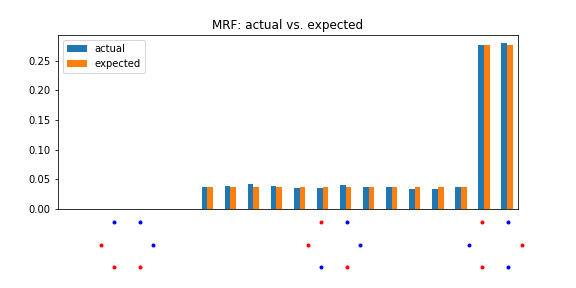

In [ ]:
plot_actual_and_expected(mrf_actual_p, mrf_expected_p, title='MRF: actual vs. expected')

## Determinantal Point Processes

The probability of chosing set $Y$ is given by

$$
    P(Y) = \det(L_Y),
$$

where the kernel matrix $L_{Y,ij}$ is specified in terms of the kernel $L(x_i, x_j) = q(x_i) k(x_i, x_j) q(x_j)$. When $q$ is chosen as $q(x) = \sqrt{p(x)}$, the determinant can be interpreted as

$$
\begin{align}
    P(Y) \propto \det(L_Y) = \det(K_Y) \prod_{i \in Y} p(x_i)
\end{align}
$$

The interactions between items, is encoded by the kernel $k$. For $P$ to be a valid probability distribution, $k$ must be [positive-definite kernel](https://en.wikipedia.org/wiki/Positive-definite_kernel). Examples, according to wikipedia, are:

- linear kernel: $k(x, y) = x \cdot y$
- polynomial kernel $k(x, y) = (x \cdot y + r)^n$
- gaussian kernel: $k(x, y) = \exp [-(x - y)^2 / 2 \sigma^2 ]$
- laplacian kernel: $k(x, y) = \exp [-\alpha (x - y) ]$

Here, we are looking at $k-DPPs$ with a fixed number of items. To draw samples, we use Gibbs sampling. With active 
elements $Y$, the probability to add candidate element $i$ to the set of active elements is determined by

$$
\begin{align}
    P(Y \cup \{ i \}) &= \det(L_Y) \det(L_{ii} - L_{iY} L_Y^{-1} L_{Yi}),
\end{align}
$$

with $L_{ii} = e_i^T L\,e_i$, $L_{iY} = e_i\,L\,P_Y$, $L_{iY}^T = L_{Yi}$, and $L_Y = P_Y\,L\,P_Y$. Here we used the unit vectors $e_i$ and the projectors $P_Y$ onto the $Y$-subspace.

In [ ]:
# gaussian kernel
L = np.exp(-euclidean_distance / 10)

# laplace kernel
#L = np.exp(-np.sqrt(euclidean_distance) / 1e3)

dpp_expected_p = {
    tuple(s): np.linalg.det(L[s, :][:, s]) 
    for s in states
    for s in [np.asarray(s, bool)]
}
dpp_expected_z = sum(dpp_expected_p.values())
dpp_expected_p = {k: p / dpp_expected_z for k, p in dpp_expected_p.items()}

In [ ]:
stats = collections.Counter()

state = np.asarray(states[0], dtype=np.bool)
inv_state = ~state

for iteration in range(10000):
    # remove point
    i = random_nonzero_choice(state)
    state[i] = False
    inv_state[i] = True
    
    # decompose the matrix
    L_sub = L[state, :][:, state]
    B = L[state, :][:, inv_state]
    D = L[inv_state, inv_state]
    
    # invert the sub matrix
    L_sub_inv = np.linalg.inv(L_sub)
    
    # calculate the determinant changes
    p = det_change(D, B, L_sub_inv)
    
    j = random_weighted_zero_choice(state, p=p)
    state[j] = True
    inv_state[j] = False
    
    if iteration > 100:
        stats[tuple(state.astype(int))] += 1

In [ ]:
dpp_actual_Z = sum(stats.values())
dpp_actual_p = {k: p / dpp_actual_Z for k, p in stats.items()}

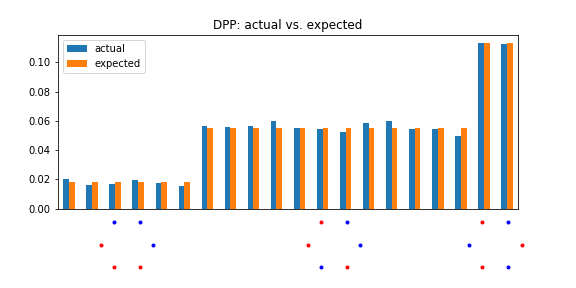

In [ ]:
plot_actual_and_expected(dpp_actual_p, dpp_expected_p, title='DPP: actual vs. expected')